# Capstone Project 1: In-Depth Analysis

### Note on Input Data Files
The pre-processed data file is too large to store on github.  The file is created, stored, and loaded locally on my machine during my analysis.  The flight and weather data files are also stored and loaded locally on my machine.

Anyone else using this code should download copies of the data files from my google drive.  A backup copy of the pre-processed data file (version uploaded on 1/21/2019), as well as copies of the input weather and flight data files, can be downloaded here: https://drive.google.com/open?id=1PkbeFC4E2Vea67YqzfooeZacI9eKd9-P  
Note that, after downloading the data files, the filepaths should be updated in the code below.

In [1]:
%matplotlib inline  

# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import collections
from scipy import stats
from glob import glob

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import OLS, ols

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
# configure DataFrame display settings
pd.options.display.max_columns = None

In [4]:
# configure seaborn settings
sns.set(style='whitegrid', font_scale=1.4)

In [5]:
# seed the pseudorandom number generator
np.random.seed(42)

## Prepare Data For Analysis

### Load the Pre-processed Data

In [6]:
# set the input directory
dir_in = 'C:/Users/Jonathon.Poage/Desktop/Springboard/Capstone_Documentation/Project_1/Data_Files/preprocessed_data/'

# set the input filepath
filename_in = 'merged_flight_weather_data_preprocessed.csv'
filepath_in = dir_in + filename_in

In [7]:
# columns to parse as dates
ts_cols_in = ['crs_dep_ts',
              'dep_ts',
              'wheels_off_ts',
              'valid']

# set dtype for each column
dict_dtype_in = {'QUARTER':np.int8,
                 'OP_UNIQUE_CARRIER':'category',
                 'OP_CARRIER_FL_NUM':np.int16,
                 'ORIGIN':'category',
                 'DEST':'category',
                 'DEP_TIME_BLK':'category',
                 'origin_timezone':'category',
                 'station':'category',
                 'skyc1':'category',
                 'skyc2':'category',
                 'skyc3':'category',
                 'skyc4':'category',
                 'skyl1':np.float64,
                 'skyl2':np.float64,
                 'skyl3':np.float64,
                 'skyl4':np.float64,
                 'wxcodes':'category',
                 'station_timezone':'category'}

In [8]:
# load the data -- should take about 1 minute
df = pd.read_csv(filepath_in,
                 parse_dates=ts_cols_in,
                 dtype=dict_dtype_in,
                 low_memory=False)

### Filter the Pre-processed Data
Filter out all data points associated with non-zero values for the reported delay categories.  Focus on the relationships between departure delays and weather variables.

In [9]:
# filter the dataframe to compare delays with weather variables
df_no_delay_cat = df[((df.CARRIER_DELAY == 0) | df.CARRIER_DELAY.isnull())
                   & ((df.WEATHER_DELAY == 0) | df.WEATHER_DELAY.isnull())
                   & ((df.NAS_DELAY == 0) | df.NAS_DELAY.isnull())
                   & ((df.SECURITY_DELAY == 0) | df.SECURITY_DELAY.isnull())
                   & ((df.LATE_AIRCRAFT_DELAY == 0) | df.LATE_AIRCRAFT_DELAY.isnull())]

### Resample the Data

Resample data points for each station separately.  Hourly weather observations are too close together to be considered independent.  For each station, select data points that are at least 7 hours apart.  

In [10]:
# set the resample frequency
FREQ = '7H'

# resample for each station
df_rs = df_no_delay_cat.sort_values(['station','valid']).groupby(['station', pd.Grouper(key='valid', freq=FREQ)]).head(1)

# filter out times that are too close together
df_rs = df_rs[df_rs.valid.diff() >= pd.to_timedelta(FREQ)]

# reset the index
df_rs.reset_index(drop=True, inplace=True)

### Prepare a DataFrame with Feature and Target Variables

In [11]:
# dict to map weather codes
dict_wconds = {'-RA':'RAIN',
               'RA':'RAIN',
               '+RA':'RAIN',
               '-DZ':'RAIN',
               'DZ':'RAIN',
               '+DZ':'RAIN',
               'FG':'FOG',
               'BR':'FOG',
               'MIFG':'FOG',
               '-SN':'SNOW/ICE',
               'SN':'SNOW/ICE',
               '+SN':'SNOW/ICE',
               'GR':'SNOW/ICE',
               '-GS':'SNOW/ICE',
               'GS':'SNOW/ICE',
               '+GS':'SNOW/ICE',
               '-PL':'SNOW/ICE',
               'PL':'SNOW/ICE',
               '+PL':'SNOW/ICE',
               '-SG':'SNOW/ICE',
               'SG':'SNOW/ICE',
               '+SG':'SNOW/ICE',
               'IC':'SNOW/ICE',
#               '-TS':'THUNDERSTORM',
#               'TS':'THUNDERSTORM',
#               '+TS':'THUNDERSTORM',
               np.nan:'CLEAR'}

# map the weather codes
df_rs['wcond'] = df_rs.wxcodes.map(dict_wconds).fillna('OTHER')

In [12]:
# list of numeric weather variable column labels
numeric_weather_cols = ['tmpf',
                        #'dwpf',  excluding dew point because it can be derived from temperature and relative humidity
                        'relh',
                       # 'drct',   excluding wind direction because runway directions vary
                        'sknt',
                        'p01i',
                        'alti',
                        #'mslp', excluding mslp. Preliminary analysis showed it is highly correlated with alti
                        'vsby',
                        'gust',  
                        'skyl1'] #,  
                        #'skyl2',    excluding altitudes for sky levels 2-4.   
                        #'skyl3',        only use the altutide of the lowest
                        #'skyl4']        sky level
            
# list categorical weather variable column names
cat_cols = ['skyc1', 'wcond']  # excluding sky levels 2-4. 

Notes on excluded weather variables:  
- dwpf not included -- dwpf can be derived from tmpf and relh. No need to include all three features.
- drct not included -- wind direction alone is not useful.  A rigorous analysis would involve the wind direction relative to the runway direction for each flight.
- mslp not included -- preliminary results indicated it was strongly correlated with alti.
- skyl2, skyl3, skyl4 not included -- this analysis uses the altitude of the lowest sky level. 
- skyc2, skyc3, skyc4 not included -- this analysis uses the lowest sky level.

In [13]:
# isolate a dataframe with features and target variable
df_ft_prep = df_rs[['DEP_DELAY'] + numeric_weather_cols + cat_cols].copy()

# replace NaN values in gust with a sentinel value
GUST_NAN = -999
df_ft_prep.loc[(df_ft_prep.gust.isnull()), 'gust'] = GUST_NAN

# replace the NaN values in skyl1 when skyc1 == 'CLR'
SKYL1_NAN = 42000  # sentinel value
df_ft_prep.loc[((df_ft_prep.skyc1 == 'CLR') & (df_ft_prep.skyl1.isnull())), 'skyl1'] = SKYL1_NAN

# drop all missing values
df_ft_prep = df_ft_prep.dropna()

# reset the index
df_ft_prep = df_ft_prep.reset_index(drop=True)

The variable skyl1 has missing values when skyc1 is CLR. There is some ambiguity for what the sky level 1 altitude should be when skies are clear.   For this analysis, each NaN value for skyl1 when skyc1 is CLR was replaced with a sentinel value of 42000 feet.  This value was chosen after considering typical service ceilings for commercial aircraft.  The implications of setting a value for the sky level when skyc1 is CLR were taken into consideration for the remainder of the analysis.  

## Comparison Between Weather Conditions

###  Check Conditions for Statistical Inference

              mean  median  count
wcond                            
FOG      -1.126074    -3.0    349
CLEAR    -0.930507    -3.0  17714
RAIN     -0.287091    -3.0    519
OTHER     1.796190    -2.0    525
SNOW/ICE  1.913793    -2.0     58


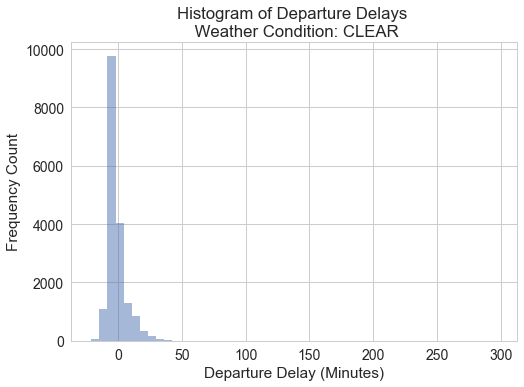

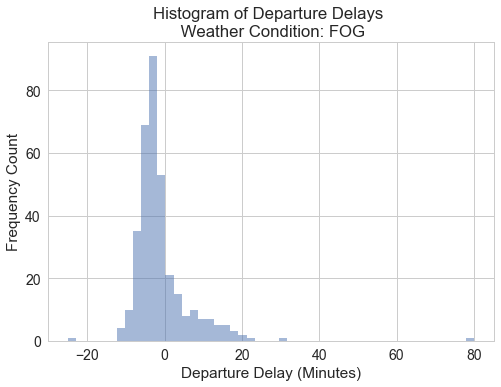

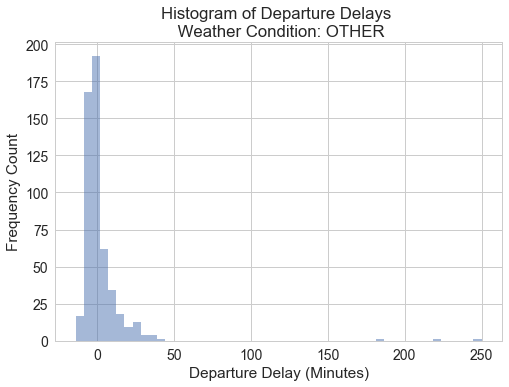

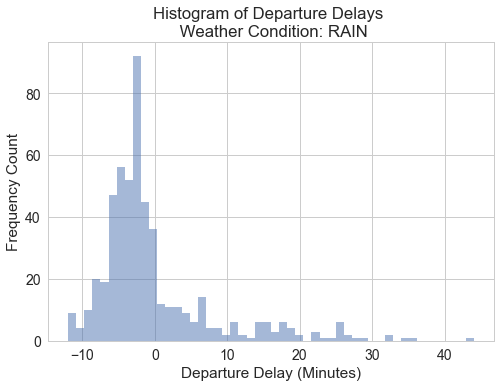

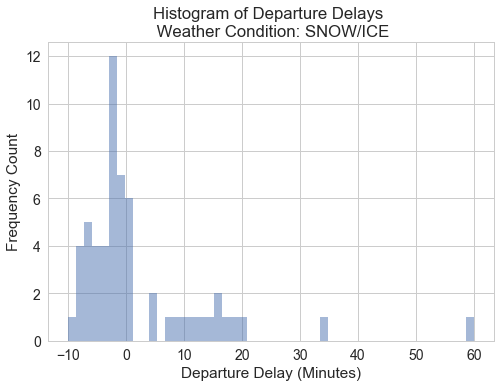

In [14]:
# group departure delays by weather condition
df_ft_groups = df_ft_prep.groupby('wcond')['DEP_DELAY']

# find the mean, median, and count for each weather condition
mean_med_count = df_ft_groups.agg([np.mean, np.median, 'count'])

# print the means, medians, and counts
print(mean_med_count.sort_values('mean'))

# plot a histogram for each weather condition
for k, v in df_ft_groups:
    plt.figure()
    v.hist(label=k, alpha=0.5, bins=50)
    plt.xlabel('Departure Delay (Minutes)')
    plt.ylabel('Frequency Count')
    plt.title('Histogram of Departure Delays \n Weather Condition: ' + str(k))

### H-Test

In [15]:
# empty dict of arrays
a_all = {}

# loop through every weather condition
for c in df_ft_prep.wcond.unique():
    a_c = df_ft_prep.DEP_DELAY[df_ft_prep.wcond == c].values
    a_all[c] = a_c

# perform an H-test
H, p = stats.kruskal(*a_all.values())
print('Kruskal-Wallis H statistic = %.3f \t p-value = %.2e' % (H, p))

Kruskal-Wallis H statistic = 213.480 	 p-value = 4.74e-45


### Two-Sample t-Tests

In [16]:
# create an array of departure delays for wcond == CLEAR
a_clr = a_all['CLEAR']

# loop through every weather condition other than clear
for wc in a_all.keys():
    if wc != 'CLEAR':
        a_wc = a_all[wc]
        
        # two-tailed two-sample t-test
        t_score, p_value = stats.ttest_ind(a_wc, a_clr, equal_var=False)
        
        # find the p-value for the corresponding one-tailed t-test
        if t_score >= 0:
            p_value = p_value / 2
        else:
            p_value = 1 - (p_value / 2)
        
        # print the t-scores and p-values
        print('\n', str(wc))
        print('t-score = %.2f \t p-value (one-tailed) = %.4f' % (t_score, p_value))


 SNOW/ICE
t-score = 1.86 	 p-value (one-tailed) = 0.0337

 OTHER
t-score = 3.33 	 p-value (one-tailed) = 0.0005

 FOG
t-score = -0.46 	 p-value (one-tailed) = 0.6789

 RAIN
t-score = 1.73 	 p-value (one-tailed) = 0.0420


## Linear Regression

### Prepare Feature and Target Variable DataFrames

In [17]:
# define target columns
target_cols = ['DEP_DELAY']

# define feature columns
feature_cols = ['tmpf', 
                'relh',
                'sknt',
                'alti',
                'vsby',
                'skyl1']

# dataframe with target variable(s)
df_t = df_ft_prep[target_cols]

# dataframe with feature variables
df_f = df_ft_prep[feature_cols]

Notes on additional weather variables excluded from Linear Regression:  
- p01i not included -- this feature has an insufficient amount of data with positive values.  
- gust not included -- this feature has too many missing values.
- skyc1 not included -- this portion of the analysis uses the sky level 1 altitude without specifying the sky level 1 coverage. 
- wcond not included -- this feature is excluded from this portion of the analysis because it provides redundant information.  For example, foggy conditions have low visibility.  A separate analysis evaluated the relationship between departure delays and different weather conditions.

### Feature Importance

In [18]:
# get feature and target variable arrays
X = df_f.values
y = df_t.values

In [19]:
# create an instance of StandardScaler()
scaler = StandardScaler()

# get standardized features array
X_s = scaler.fit_transform(X)

# dataframe of standardized features
df_f_s = pd.DataFrame(X_s)
df_f_s.columns = df_f.columns

# dataframe of standardized features with intercept column
df_f_s_with_intercept = df_f_s.copy()
df_f_s_with_intercept['intercept'] = 1

In [20]:
# create a grid for the alpha parameter

# first grid search homes in on alpha
#alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
# first grid search chose alpha = 0.01

# second grid search refines choice of alpha
alphas_2 = [0.008, 0.009, 0.01, 0.02, 0.03, 0.04]

# perform a grid search using LassoCV
lassocv = LassoCV(alphas=alphas_2, random_state=5, cv=10)
lassocv.fit(X_s, y.ravel())

# best alpha
best_alpha = lassocv.alpha_
print('best alpha =', best_alpha)

best alpha = 0.02


In [21]:
# Lasso regression with best alpha
m = OLS(df_t, df_f_s_with_intercept)
results = m.fit_regularized(alpha=best_alpha, L1_wt=1)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              DEP_DELAY   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     32.62
Date:                Fri, 22 Feb 2019   Prob (F-statistic):           2.47e-39
Time:                        15:39:11   Log-Likelihood:                -69913.
No. Observations:               19165   AIC:                         1.398e+05
Df Residuals:                   19158   BIC:                         1.399e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
tmpf           0.2667      0.074      3.599      0.0

## Conditional Linear Regression

### Identify Ideal Conditions for Each Feature

In [22]:
# create a copy of the feature and target variable DataFrame
df_fixed = df_ft_prep.copy()

# print the value counts for wcond
print(df_fixed.wcond.value_counts(), '\n')

# print the value counts for skyc1
print(df_fixed.skyc1.value_counts(), '\n')

# print descriptive statistics for the numerical variables
print(df_fixed.describe())

CLEAR       17714
OTHER         525
RAIN          519
FOG           349
SNOW/ICE       58
Name: wcond, dtype: int64 

FEW    9574
SCT    3158
CLR    2657
BKN    2506
OVC    1196
VV       74
Name: skyc1, dtype: int64 

          DEP_DELAY          tmpf          relh          sknt          p01i  \
count  19165.000000  19165.000000  19165.000000  19165.000000  19165.000000   
mean      -0.833342     62.027218     60.713127      7.884638      0.002039   
std        9.338046     17.084755     23.490072      4.953597      0.018789   
min      -25.000000     -9.900000      1.500000      0.000000      0.000000   
25%       -5.000000     51.100000     43.990000      4.000000      0.000000   
50%       -3.000000     62.100000     64.260000      7.000000      0.000000   
75%        0.000000     73.940000     80.100000     11.000000      0.000000   
max      297.000000    114.100000    100.000000     37.000000      0.780000   

               alti          vsby          gust         skyl1  
count 

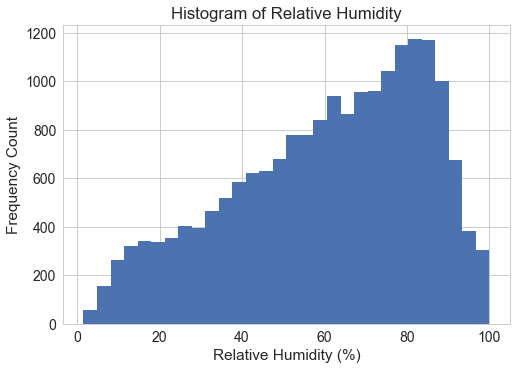

In [23]:
df_fixed.relh.hist(bins=30)
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Frequency Count')
plt.title('Histogram of Relative Humidity')

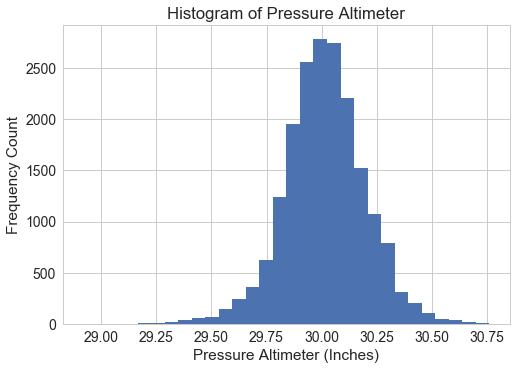

In [24]:
df_fixed.alti.hist(bins=30)
plt.xlabel('Pressure Altimeter (Inches)')
plt.ylabel('Frequency Count')
plt.title('Histogram of Pressure Altimeter')

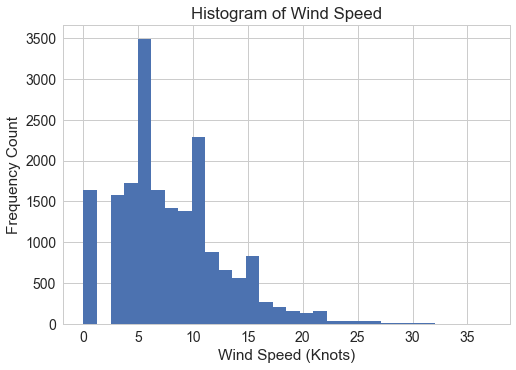

In [25]:
df_fixed.sknt.hist(bins=30)
plt.xlabel('Wind Speed (Knots)')
plt.ylabel('Frequency Count')
plt.title('Histogram of Wind Speed')

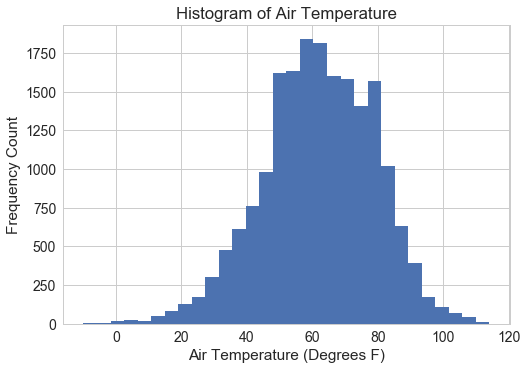

In [26]:
df_fixed.tmpf.hist(bins=30)
plt.xlabel('Air Temperature (Degrees F)')
plt.ylabel('Frequency Count')
plt.title('Histogram of Air Temperature')

In [27]:
# Set Conditions for categorical variables

# use sky level 1 == 'CLR' -- add 'FEW' if not enough data points
skyc1_fixedvalues = ['CLR']
skyc1_cond = (df_fixed.skyc1.isin(skyc1_fixedvalues))

# use wcond == 'CLEAR'
wcond_fixedvalues = ['CLEAR']
wcond_cond = (df_fixed.wcond.isin(wcond_fixedvalues))

# set conditions for numerical variables

# sky level 1 altitude is equal to its NaN sentinel value for when skyc1 == 'CLR'
skyl1_cond = (df_fixed.skyl1 == SKYL1_NAN) 

# max visibility of 10
vsby_cond = (df_fixed.vsby == 10)

# gust is equal to its NaN sentinel value
gust_cond = (df_fixed.gust == GUST_NAN)

# histogram of alti is fairly normal. MSLP is 29.92, and most stations are above sea level.  exact limits are arbitrary
alti_cond = ((df_fixed.alti >= 29.7) & (df_fixed.alti <= 30.3))

# no rainfall
p01i_cond = (df_fixed.p01i == 0)

# Beaufort wind scale -- gentle breeze or lighter.  
sknt_cond = (df_fixed.sknt <= 10)

# linear regression showed negative coefficient for relh.  histogram shows some skew.
relh_cond = (df_fixed.relh >= 50) 

# above freezing, not too hot.  histogram is fairly normal.  exact limits are arbitrary
tmpf_cond = ((df_fixed.tmpf >= 40) & (df_fixed.tmpf <= 90))

### Set Fixed Conditions

In [28]:
# df for departure delays vs wind speed
df_ws = df_fixed[skyc1_cond
               & wcond_cond
               & skyl1_cond
               & vsby_cond
               & gust_cond
               & alti_cond
               & p01i_cond
               & relh_cond
               & tmpf_cond]

df_ws = df_ws[['DEP_DELAY', 'sknt']].reset_index(drop=True)

# df for departure delays vs sky level 1 altitude
df_sl1 = df_fixed[wcond_cond
                & vsby_cond
                & gust_cond
                & alti_cond
                & p01i_cond
                & sknt_cond
                & relh_cond
                & tmpf_cond]

df_sl1 = df_sl1[['DEP_DELAY', 'skyl1', 'skyc1']].reset_index(drop=True)

### Departure Delays vs Wind Speed

In [29]:
# EDA of wind speed under fixed conditions
df_ws.describe()

,DEP_DELAY,sknt
count,1074.000000,1074.000000
mean,-2.010242,5.690875
std,6.698603,3.887918
min,-20.000000,0.000000
25%,-6.000000,3.000000
50%,-3.000000,5.000000
75%,0.000000,8.000000
max,34.000000,25.000000


In [30]:
# perform a linear regression
mws = ols('DEP_DELAY ~ sknt', df_ws).fit()

# get the slope and intercept
slope = mws.params['sknt']
intercept = mws.params['Intercept']

eq_string_ws = '[Best Fit]: y = %.2f + %.2f x' % (intercept, slope) 

# print the summary
print(mws.summary())

                            OLS Regression Results                            
Dep. Variable:              DEP_DELAY   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     11.48
Date:                Fri, 22 Feb 2019   Prob (F-statistic):           0.000729
Time:                        15:39:13   Log-Likelihood:                -3560.4
No. Observations:                1074   AIC:                             7125.
Df Residuals:                    1072   BIC:                             7135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.0196      0.361     -8.371      0.0

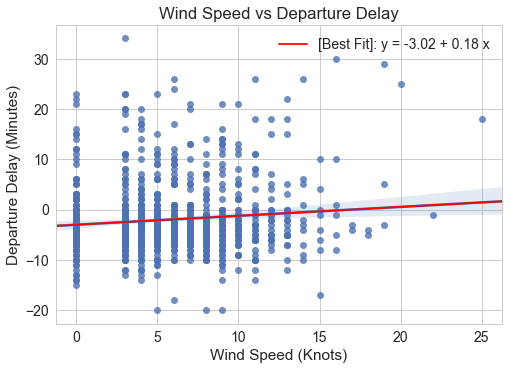

In [31]:
# make a scatterplot with the best fit line
sns.regplot(x='sknt', y='DEP_DELAY', data=df_ws)

# overlay the best fit line
xs = np.array(plt.xlim())
ys = xs * slope + intercept
plt.plot(xs, ys, '-r', label=eq_string_ws)

# add labels and legend
plt.xlabel('Wind Speed (Knots)')
plt.ylabel('Departure Delay (Minutes)')
plt.title('Wind Speed vs Departure Delay')
plt.legend()

### Departure Delays vs Lowest Sky Level Altitude

In [32]:
# EDA of Sky Level 1 Altitude under fixed conditions
df_sl1.describe()

,DEP_DELAY,skyl1
count,6656.000000,6656.000000
mean,-1.419321,12594.906851
std,8.226514,14135.032689
min,-21.000000,100.000000
25%,-6.000000,2400.000000
50%,-3.000000,5000.000000
75%,0.000000,20000.000000
max,263.000000,42000.000000


                            OLS Regression Results                            
Dep. Variable:              DEP_DELAY   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     22.95
Date:                Fri, 22 Feb 2019   Prob (F-statistic):           1.70e-06
Time:                        15:39:14   Log-Likelihood:                -23459.
No. Observations:                6656   AIC:                         4.692e+04
Df Residuals:                    6654   BIC:                         4.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.9896      0.135     -7.339      0.0

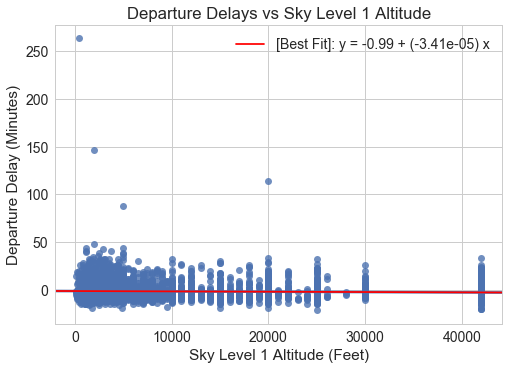

In [33]:
# perform a linear regression
msl1 = ols('DEP_DELAY ~ skyl1', df_sl1).fit()

# get the slope and intercept
slope = msl1.params['skyl1']
intercept = msl1.params['Intercept']

eq_string = '[Best Fit]: y = %.2f + (%.2e) x' % (intercept, slope) 

# print the summary
print(msl1.summary())

# make a scatterplot with the best fit line 
sns.regplot(x='skyl1', y='DEP_DELAY', data=df_sl1)

# overlay the best fit line
xs = np.array(plt.xlim())
ys = xs * slope + intercept
plt.plot(xs, ys, '-r', label=eq_string)

# add labels and legend
plt.xlabel('Sky Level 1 Altitude (Feet)')
plt.ylabel('Departure Delay (Minutes)')
plt.title('Departure Delays vs Sky Level 1 Altitude')
plt.legend()

The comparison of departure delays vs sky level 1 altitudes is continued below by removing the data points with skyc1 == 'CLR'.  The motivation for this is that when skyc1 == 'CLR', the missing skyl1 values were set to a sentinel value.  The results of a regression may vary depending on the value chosen for the sentinel.

The analysis below examines the relationship between departure delays and sky level 1 altitudes when skyc1 != 'CLR'.  There are several outliers with large departure delays that influence the linear regression results, so two separate linear regressions were performed.  One regression included all data points, and the other excluded the data points with departure delays >= 1 hour. The results are displayed below.   

[Everything above this cell has been validated.]

[TO DO:  validate everything below this cell!]

In [34]:
df_sl1.skyc1.unique()[-1]

'CLR'

All Delays Included
                            OLS Regression Results                            
Dep. Variable:              DEP_DELAY   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     12.49
Date:                Fri, 22 Feb 2019   Prob (F-statistic):           0.000412
Time:                        15:39:15   Log-Likelihood:                -20263.
No. Observations:                5695   AIC:                         4.053e+04
Df Residuals:                    5693   BIC:                         4.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.8967      0.156

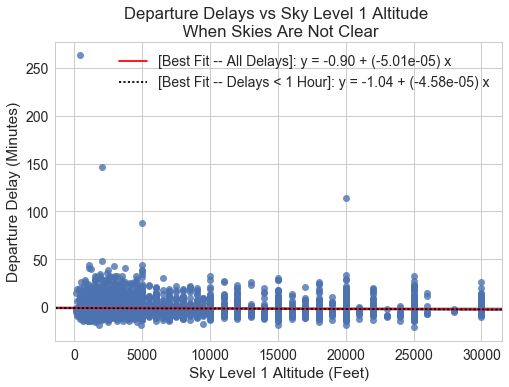

In [35]:
# only look at data points when skyc1 != 'CLR'
df_sl1_notCLR = df_sl1[df_sl1.skyc1 != 'CLR']

# perform a linear regression
msl1_notCLR = ols('DEP_DELAY ~ skyl1', df_sl1_notCLR).fit()

# get the slope and intercept
slope_notCLR = msl1_notCLR.params['skyl1']
intercept_notCLR = msl1_notCLR.params['Intercept']

eq_string_notCLR = '[Best Fit -- All Delays]: y = %.2f + (%.2e) x' % (intercept_notCLR, slope_notCLR) 

# print the summary
print('All Delays Included')
print(msl1_notCLR.summary())

# remove outlier data points with departure delays >= 1 hour
df_sl1_notCLR_delays_lt_1hour = df_sl1_notCLR[df_sl1_notCLR.DEP_DELAY < 60]

# perform a linear regression
msl1_notCLR_delays_lt_1hour = ols('DEP_DELAY ~ skyl1', df_sl1_notCLR_delays_lt_1hour).fit()

# get the slope and intercept
slope_notCLR_delays_lt_1hour = msl1_notCLR_delays_lt_1hour.params['skyl1']
intercept_notCLR_delays_lt_1hour = msl1_notCLR_delays_lt_1hour.params['Intercept']

eq_string_notCLR_delays_lt_1hour = '[Best Fit -- Delays < 1 Hour]: y = %.2f + (%.2e) x' % (intercept_notCLR_delays_lt_1hour, slope_notCLR_delays_lt_1hour) 

# print the summary
print('\n Only Delays < 1 Hour Included')
print(msl1_notCLR_delays_lt_1hour.summary())

# make a scatterplot with the best fit lines
sns.regplot(x='skyl1', y='DEP_DELAY', data=df_sl1_notCLR)

# overlay the best fit lines
xs = np.array(plt.xlim())
ys_notCLR = xs * slope_notCLR + intercept_notCLR
ys_notCLR_delays_lt_1hour = xs * slope_notCLR_delays_lt_1hour + intercept_notCLR_delays_lt_1hour
plt.plot(xs, ys_notCLR, '-r', label=eq_string_notCLR)
plt.plot(xs, ys_notCLR_delays_lt_1hour, ':k', label=eq_string_notCLR_delays_lt_1hour)

# add labels and legend
plt.xlabel('Sky Level 1 Altitude (Feet)')
plt.ylabel('Departure Delay (Minutes)')
plt.title('Departure Delays vs Sky Level 1 Altitude \n When Skies Are Not Clear')
plt.legend()